# Product Recognition on Store Shelves
Project for Computer Vision And Image Processing exam, Matteo Giri (matteo.giri@studio.unibo.it)

## Step C - Whole Shelf Challenge
To solve this step, I used the same object detection pipeline used for Step B, which involves **Local Invariant Features** + **GHT (Generalized Hough Transform)**, with the addition of a super-resolution operation on the scene images.

### 1- Preliminary operations

In [1]:
import math
import numpy as np
import cv2
from matplotlib import pyplot as plt

from scipy.ndimage import maximum_filter
from scipy.ndimage import minimum_filter

from cv2 import dnn_superres

colors = [(255,0,0),(0,255,0),(0,0,255), (220,0,255),(255,255,0),(0,128,255),(0,255,255),(255,128,0),(255,0,128),(255,100,255),(255,255,255),(0,0,0),(128,128,128),(128,0,0),(0,128,0),(0,0,128), (220,0,128),(128,128,0),(0,128,128),(0,128,255),(255,56,0),(128,0,56),(255,153,255),(56,56,56),(128,0,56),(100,80,70),(100,0,200),(0,255,0),(0,0,255), (220,0,255),(255,255,0),(0,128,255),(0,255,255),(255,128,0),(255,0,128),(255,100,255),(255,255,255),(0,0,0),(128,128,128)]

### 2- Super-resolution

Given that the train images considered for this step contain numerous objects, it is beneficial to increase the resolution of the image to facilitate the operations of the object detection pipeline (more keypoints detected, better distribution in the accumulator array).

To perform up-scaling of the images, I used the OpenCV super-resolution library **dnn_superres**, which allows applying a super-resolution model to an image to obtain a scaled version while trying to maintain its quality and details. The model used is *LapSRN*, which is well-balanced between performance and speed, to perform up-scaling by a factor of 4 times the initial resolution.

In [2]:
img_trains = []
img_trains.append(cv2.imread('object_detection_project/scenes/h1.jpg'))
img_trains.append(cv2.imread('object_detection_project/scenes/h2.jpg'))
img_trains.append(cv2.imread('object_detection_project/scenes/h3.jpg'))
img_trains.append(cv2.imread('object_detection_project/scenes/h4.jpg'))
img_trains.append(cv2.imread('object_detection_project/scenes/h5.jpg'))

sr = dnn_superres.DnnSuperResImpl_create()
sr.readModel("models/LapSRN_x4.pb")
sr.setModel("lapsrn", 4)

for i in range(len(img_trains)):
    result = sr.upsample(img_trains[i])
    print("after upscaling: " + str(result.shape))
    path = 'object_detection_project/scenes/h' + str(i+1) + '_upscaled.jpg'
    cv2.imwrite(path,result)

after upscaling: (1920, 2560, 3)
after upscaling: (1920, 2560, 3)
after upscaling: (1920, 2560, 3)
after upscaling: (1920, 2560, 3)
after upscaling: (1920, 2560, 3)


### 3- Loading of query and test images
Since the query images are of different sizes, they are all resized to 250x180px so that they all have the same dimensions and avoid inconsistencies in the detection of keypoints.

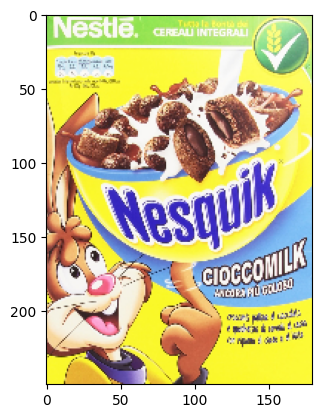

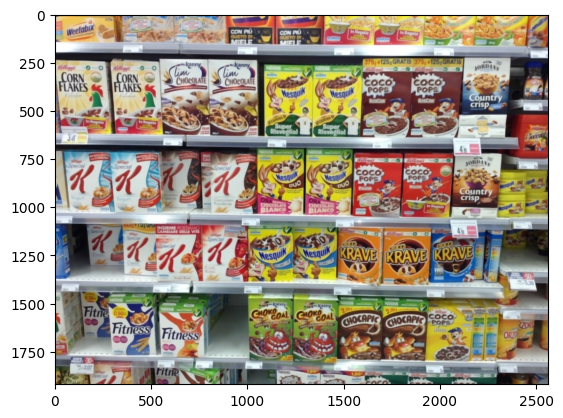

In [3]:
#Load model images
queries = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26']
img_queries = []
for query in queries:
    img_queries.append(cv2.imread('object_detection_project/models/'+ query + '.jpg'))

for i in range(len(img_queries)):
    img_queries[i] = cv2.resize(img_queries[i],(180,250))
    
plt.imshow(cv2.cvtColor(img_queries[0], cv2.COLOR_BGR2RGB))
plt.show()

#Load scene images
trains = ['h1_upscaled','h2_upscaled','h3_upscaled','h4_upscaled','h5_upscaled']
img_trains = []
for train in trains:
    img_trains.append(cv2.imread('object_detection_project/scenes/' + train + '.jpg'))

plt.imshow(cv2.cvtColor(img_trains[0], cv2.COLOR_BGR2RGB))
plt.show()

### 4- Keypoints detection and description
The function *get_kp_and_des* takes an image and the number of color channels of the image as input and returns two lists containing the detected keypoints and their corresponding descriptors. The two returned lists are divided by the color channels of the image, so that matching can be performed separately for each channel and obtain a more robust result.

In [4]:
def get_kp_and_des(img, channels=3):
    sift = cv2.xfeatures2d.SIFT_create()
    kp = []
    des = []
    for i in range(channels): #for each color channel of the image
        channel = img[:,:,i]
        kp_c = sift.detect(channel)
        kp_c, des_c = sift.compute(channel,kp_c)
        kp.append(kp_c)
        des.append(des_c)
    return kp,des

### 5- Feature matching
The function *match_descriptors* takes as input the lists containing the descriptors of a query image and a train image, and returns the list containing the matches found by the Flann-Based Matcher divided by color channel.

This time, the **Lowe's Ratio Test** is not used because we do not want to keep only the best match found with knnMatch. Instead, we want to have access to the k best matches for a keypoint, as there might be multiple instances of a query object in a train image. However, this means that any incorrect matches are not filtered out. Nonetheless, this is not an issue because they will be implicitly discarded during the GHT phase (incorrect matches do not contribute to increasing a maximum in the accumulator array).

In [5]:
def match_descriptors(des_query,des_train, channels=3):
    good = []
    for i in range(channels): #for each color channel of the image
        # Matching and finding the 2 closest elements for each query descriptor.
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(des_query[i],des_train[i],k=3)

        good_c = []
        for m,n,o in matches:
            good_c.append(m)
            good_c.append(n)
            good_c.append(o)
        good.append(good_c)
    return good


### 6- Generalized Hough Transform
The function *generalized_hough* takes as input the train image (to create the accumulator), the keypoints found in the query and train images, the matches obtained with the *match_descriptors* function, the quantization degree (i.e., the size of each cell in the accumulator), and the number of color channels. It returns the filled accumulator array with the cast votes and a list containing the centroid position expressed by each keypoint.

In particular:

1. The centroid of the object is chosen as the reference point, calculated as the mean position of all the keypoints detected in the query image.
2. An accumulator is initialized with all zeros.
3. The joining vector (centroid position - keypoint position) is calculated for each keypoint detected in the query image that has a match in the train image.
4. The estimated centroid position is calculated for each keypoint in the train image (keypoint position + joining vector), using the joining vector corresponding to the matched keypoint in the query image. The joining vector is first rotated by an angle delta_r and scaled by an amount delta_s to achieve rotation and scale invariance. If the calculated position does not go beyond the borders of the image, a vote is cast in the accumulator, and the coordinates (row and column of the accumulator) of the centroid are added to the indexing list.
It should be noted that points 3 and 4 are performed for each color channel of the image, although the votes are then expressed in the same accumulator.

The function *rotate* allows rotating a vector by a given angle.

In [6]:
def generalized_hough(img_train, kp_query, kp_train, good, q_degree=100, channels=3):
    #1- Choose a reference point
    kp_query_sum = []
    for i in range(channels):
        kp_query_sum += kp_query[i]           
    kp_positions = np.array([kp.pt for kp in kp_query_sum])
    barycentre = np.mean(kp_positions, axis=0)
    
    #2- initialize an accumulator array
    accumulator = np.zeros((img_train.shape[0]//q_degree+1, img_train.shape[1]//q_degree+1))
    
    train_barycentres = [] #list containing position of calculated barycenters of the train_image keypoints in the accumulator
    
    for i in range(channels): #for each color channel of the image
        kp_query_matches = [kp_query[i][m.queryIdx] for m in good[i]]
        kp_train_matches = [kp_train[i][m.trainIdx] for m in good[i]]
        
        #3- compute the joining vectors of the matching kp
        kp_query_matches_p = np.array([kp.pt for kp in kp_query_matches])
        joining_vectors = [barycentre - kp_position for kp_position in kp_query_matches_p]
        
        #4- compute the position of the barycentre and cast the vote
        train_barycentres_c = [] 
        for j in range(len(kp_query_matches)):
            kp_query_match = kp_query_matches[j]
            kp_train_match = kp_train_matches[j]
            vector = joining_vectors[j]

            delta_s = kp_train_match.size / kp_query_match.size                 #for scale invariance
            delta_r = math.radians(kp_train_match.angle - kp_query_match.angle) #for rotation invariance

            bary = kp_train_match.pt + delta_s*rotate(vector,delta_r)
            acc_row = int(bary[1]//q_degree)
            acc_col = int(bary[0]//q_degree)
            if acc_row < accumulator.shape[0] and acc_col < accumulator.shape[1] and acc_row >= 0 and acc_col >= 0 :     #check that calculated bary doesn't fall outside image      
                accumulator[acc_row,acc_col] += 1
                train_barycentres_c.append((acc_row,acc_col))
            else:
                train_barycentres_c.append((-1,-1))
        train_barycentres.append(train_barycentres_c)
    return accumulator,train_barycentres

def rotate(vector,angle):
    cos = math.cos(angle)
    sin = math.sin(angle)

    x_new = vector[0]*cos - vector[1]*sin
    y_new = vector[0] *sin + vector[1] * cos
    rotated_vector = np.array((x_new, y_new))
    return rotated_vector


### 7- Accumulator array maxima
The function *find_maxima* takes as input the accumulator and the matches found with the match_descriptors function, and returns the coordinates (rows and columns) of the maxima of the accumulator and the value of the accumulator at those positions. The function also receives three parameters:

1. "maxima_trs" is the threshold beyond which a value in the accumulator array will be considered as an actual maximum and therefore as the centroid of a detected object.
2. "maxima_trs_range" is a range within which the values of neighboring accumulators are aggregated.
3. "ratio_trs" is the threshold that allows recognizing a value in the accumulator array as the centroid of a detected object if the ratio between that value (i.e., the number of keypoints casting a vote in that region) and the total number of matches is above that threshold. This threshold is added to avoid inconsistencies between different images: in larger train images, more keypoints and matches could be found, which may lead to higher values in the accumulator array and potentially surpassing the maxima_trs threshold even if they are not true maxima. Therefore, computing the ratio with the total number of matches helps "normalize" the treatment of various images.
Firstly, in the function, the values of potential maxima (accumulator value greater than maxima_trs-maxima_trs_range) in the accumulator are aggregated with the values of their neighbors (adjacent positions) to prevent situations where a true centroid is divided between two nearby regions and therefore fails to reach the maxima_trs threshold to be considered as a maximum.

Subsequently, the maxima and minima of the accumulator are found using the "maximum_filter" and "minimum_filter" functions from the "Scipy" library, and their difference is compared to maxima_trs to find the true maxima.

Finally, the ratio_trs is applied to further filter the maxima and their respective positions (row, column) returned.

The values of the positions of the maxima in the accumulator are returned to perform subsequent checks on any duplicate detections that could lead to incorrect results.

In [7]:
def find_maxima(accumulator,good, maxima_trs=400,maxima_trs_range=150,ratio_trs=0.2,channels=3):
     #aggregate maxima neighbourhood to avoid splits
    for col in range(accumulator.shape[1]):
        for row in range(accumulator.shape[0]):
            if accumulator[row,col] > maxima_trs-maxima_trs_range:
                sum_m = accumulator[row,col]
                if row-1 >= 0:
                    sum_m += accumulator[row-1,col]
                    accumulator[row-1,col] = 0
                if row+1 < accumulator.shape[0]:
                    sum_m += accumulator[row+1,col]
                    accumulator[row+1,col]=0
                if col-1 >= 0:
                    sum_m += accumulator[row,col-1]
                    accumulator[row,col-1]=0
                if col+1 < accumulator.shape[1]:
                    sum_m += accumulator[row,col+1]
                    accumulator[row,col+1]=0
                accumulator[row,col] = sum_m
    
    #find maxima of accumulator
    data_max = maximum_filter(accumulator, 5)
    maxima = (accumulator == data_max)
    data_min = minimum_filter(accumulator, 5)
    diff = ((data_max - data_min) > maxima_trs)
    maxima[diff == 0] = 0
    
    #ratio check
    good_sum = 0
    for i in range(channels):
        good_sum += len(good[i])        
    maxima_values_cand = accumulator[maxima] #store values for further checks in the pipeline
    maxima_ratios = accumulator[maxima]/good_sum    
    maxima_values = []
    maxima_rows = []
    maxima_cols = []
    maxima_rows_cand, maxima_cols_cand = np.where(maxima == True) #maxima positions in the accumulator array
    for i in range(len(maxima_ratios)):      
        if maxima_ratios[i] >= ratio_trs:
            maxima_rows.append(maxima_rows_cand[i])
            maxima_cols.append(maxima_cols_cand[i])
            maxima_values.append(maxima_values_cand[i])
    return maxima_rows,maxima_cols,maxima_values

### 8- Homography calculation
The function *calculate_homography* takes as input the keypoints found in the query and train images, the matches obtained with the *match_descriptors* function, the list of centroid indexing, and the position of the maximum obtained with the *find_maxima* function. It returns the homography calculated using the *findHomography* function of OpenCV (which utilizes RANSAC to obtain a robust homography).

Unlike in Step A, not all matches found are used. Only those matches are considered for which the keypoint of the train image has cast a vote in the considered maximum. This is possible thanks to the indexing list "train_barycentres". Specifically, matches are selected where the keypoint casts a vote in the position of the maximum in the accumulator and also the keypoints that cast their votes in the adjacent positions to that of the maximum, due to the aggregation performed in the *find_maxima* function.

In this phase, matches from various color channels are combined.

In [8]:
def calculate_homography(kp_query,kp_train,good,train_barycentres, maxima_row,maxima_col,channels=3):
    good_src = np.array([])
    good_dst = np.array([])
    for i in range(channels):
        src_pts = np.float32([ kp_query[i][m.queryIdx].pt for m in good[i] ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp_train[i][m.trainIdx].pt for m in good[i] ]).reshape(-1,1,2)
        
        #keep only those matches that cast the vote in the maxima position, or the positions adiacent to it
        good_src_c = np.float32([src_pts[j] for j in range(len(train_barycentres[i])) if train_barycentres[i][j] == (maxima_row,maxima_col) or train_barycentres[i][j] == (maxima_row-1,maxima_col) or train_barycentres[i][j] == (maxima_row+1,maxima_col) or train_barycentres[i][j] == (maxima_row,maxima_col-1) or train_barycentres[i][j] == (maxima_row,maxima_col+1)])
        good_dst_c = np.float32([dst_pts[j] for j in range(len(train_barycentres[i])) if train_barycentres[i][j] == (maxima_row,maxima_col) or train_barycentres[i][j] == (maxima_row-1,maxima_col) or train_barycentres[i][j] == (maxima_row+1,maxima_col) or train_barycentres[i][j] == (maxima_row,maxima_col-1) or train_barycentres[i][j] == (maxima_row,maxima_col+1)])
       
        good_src = np.vstack([good_src,good_src_c]) if good_src.size else good_src_c
        good_dst = np.vstack([good_dst,good_dst_c]) if good_dst.size else good_dst_c

    M, _ = cv2.findHomography(good_src, good_dst, cv2.RANSAC, 5.0)
    return M

### 9- Verification on Duplicate Detections
To prevent some objects in the train image from being recognized multiple times (as different objects), a verification is performed using the values of the accumulator array at the positions of the calculated maxima in the *find_maxima* function.

The function *check_double_matches* takes as input the list containing the information of the instances already found in the image (all, for each query) and the instance to be verified, and returns the new list of information and a boolean variable.

The verification works as follows:
it checks if the center of the instance to be verified is contained within the bounding box of one of the instances already detected in the image. If this happens, it means that the object was already detected as an instance of another query image, and a comparison is made between the maxima_values of the two instances. Only the information of the instance with the higher value is retained in the information list.

The boolean variable returned is True if the instance to be verified should be added to the information list, False otherwise.

In [9]:
def check_double_matches(instances_info, instance):
    check = False
    box_center = instance[2]
    value = instance[3]
    for i in range(len(instances_info)):
        for j in range(len(instances_info[i])): 
            inst_width = instances_info[i][j][0]
            inst_height = instances_info[i][j][1]
            inst_center = instances_info[i][j][2]
            inst_value = instances_info[i][j][3]
            #for each found instance check if box_center is inside the current box
            if (inst_center[0]-inst_width/2 < box_center[0] < inst_center[0]+inst_width/2 and inst_center[1]-inst_height/2 < box_center[1] < inst_center[1]+inst_height/2):
                #check if the value of the current instance is more than the value of the instance to check
                if(inst_value > value):
                    return instances_info,check #if it's more I don't change anything
                else:
                    check = True
                    del instances_info[i][j]
                    return instances_info,check #if it's less I remove it from the list
    return instances_info,True

### 10- Utility functions
The function *capproximate_rectangle* allows approximating the bounding box of the detected object with a rectangle, in order to obtain its center and dimensions (width, height). The function takes as input the points defining the bounding box of the detected object (obtained by applying the calculated homography) and returns the points defining the approximate rectangle, its dimensions, and its center.

The function *two_point_distance* returns the Euclidean distance between two points, used to calculate the dimensions of the rectangle.

In [10]:
def approximate_rectangle(points,img_dim):
    top_left = points[0][0]
    bottom_left = points[1][0]
    bottom_right = points[2][0]
    top_right = points[3][0]
    
    top_y = round((top_left[1] + top_right[1])/2)
    bottom_y = round((bottom_left[1] + bottom_right[1])/2)
    left_x = round((top_left[0]+bottom_left[0])/2)
    right_x = round((top_right[0]+bottom_right[0])/2)
    
    #create rectangle and calculate width, height and center
    rectangle = np.array(([[left_x,top_y]],[[left_x,bottom_y]],[[right_x,bottom_y]],[[right_x,top_y]]))    
    width = round(two_points_distance(rectangle[3][0],rectangle[0][0]))
    height = round(two_points_distance(rectangle[1][0],rectangle[0][0]))
    center = np.array([round((left_x+right_x)/2),round((top_y+bottom_y)/2)])
    
    #only for visualization, crop the rectangle to be rendered inside the scene 
    #top_y = top_y if top_y>0 else 0
    #bottom_y = bottom_y if bottom_y<img_dim[0] else img_dim[0]
    #left_x = left_x if left_x>0 else 0
    #right_x = right_x if right_x < img_dim[1] else img_dim[1]
    #rectangle = np.array(([[left_x,top_y]],[[left_x,bottom_y]],[[right_x,bottom_y]],[[right_x,top_y]]))
    return rectangle,width,height,center
    
    
def two_points_distance(A, B):
    return math.sqrt( np.power(A[0] - B[0], 2) +  np.power(A[1] - B[1], 2))

### 11- Complete pipeline
Below is the entire object detection pipeline applied:

For each train image, keypoints and descriptors of the image are calculated. For each query image, keypoints and descriptors are calculated and matched with the descriptors of the train image. Generalized Hough Transform (GHT) is performed, and the maxima of the returned accumulator are found.

For each found maximum (row, column), the object (query image) is considered found, and therefore, the homography is calculated. After calculating the homography, the transformation that takes us from points in the query image to points in the train image is applied, the bounding box rectangle is approximated, and the information of the detected object is saved in a list (to which the corresponding maxima_value, i.e., the value of the accumulator at position (maxima_row, maxima_col), is also added).

A verification for duplicate detections is then performed, and if this returns True, the information of the detected object is inserted into the list containing the information of all detected objects.

Finally, for each train image, the bounding boxes of the found objects are drawn, and various information is printed.

Product 0 - 2 instance(s) found:
     Instance 1 {position: (1119,1238), width: 226px, height: 295px}
     Instance 2 {position: (1348,1227), width: 222px, height: 290px}
Product 1 - 1 instance(s) found:
     Instance 1 {position: (2069,1240), width: 220px, height: 289px}
Product 2 - 2 instance(s) found:
     Instance 1 {position: (146,432), width: 246px, height: 365px}
     Instance 2 {position: (424,436), width: 235px, height: 367px}
Product 3 - 2 instance(s) found:
     Instance 1 {position: (1112,1636), width: 232px, height: 326px}
     Instance 2 {position: (1346,1644), width: 229px, height: 325px}
Product 4 - 2 instance(s) found:
     Instance 1 {position: (668,429), width: 276px, height: 388px}
     Instance 2 {position: (920,432), width: 281px, height: 392px}
Product 5 - 2 instance(s) found:
     Instance 1 {position: (1220,391), width: 181px, height: 280px}
     Instance 2 {position: (1476,396), width: 183px, height: 283px}
Product 6 - 0 instance(s) found:
Product 7 - 2 instan

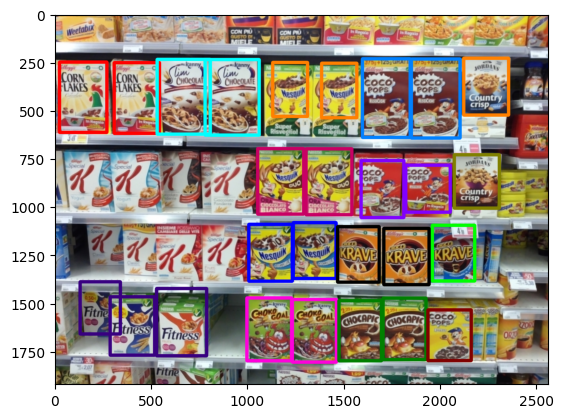

-------------------------------------------------------------------------------------------------
Product 0 - 2 instance(s) found:
     Instance 1 {position: (1013,1302), width: 222px, height: 287px}
     Instance 2 {position: (1248,1306), width: 220px, height: 284px}
Product 1 - 1 instance(s) found:
     Instance 1 {position: (1940,1324), width: 222px, height: 293px}
Product 2 - 1 instance(s) found:
     Instance 1 {position: (314,473), width: 176px, height: 272px}
Product 3 - 3 instance(s) found:
     Instance 1 {position: (996,1694), width: 225px, height: 309px}
     Instance 2 {position: (1224,1704), width: 227px, height: 307px}
     Instance 3 {position: (1450,1696), width: 221px, height: 309px}
Product 4 - 2 instance(s) found:
     Instance 1 {position: (570,522), width: 273px, height: 380px}
     Instance 2 {position: (815,532), width: 266px, height: 383px}
Product 5 - 2 instance(s) found:
     Instance 1 {position: (1077,491), width: 180px, height: 272px}
     Instance 2 {posit

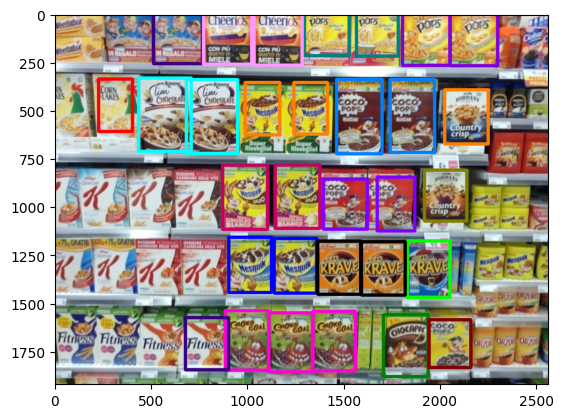

-------------------------------------------------------------------------------------------------
Product 0 - 2 instance(s) found:
     Instance 1 {position: (1388,1240), width: 216px, height: 281px}
     Instance 2 {position: (1621,1247), width: 222px, height: 286px}
Product 1 - 1 instance(s) found:
     Instance 1 {position: (2345,1281), width: 242px, height: 302px}
Product 2 - 3 instance(s) found:
     Instance 1 {position: (746,446), width: 149px, height: 245px}
     Instance 2 {position: (144,1554), width: 189px, height: 279px}
     Instance 3 {position: (332,1544), width: 181px, height: 252px}
Product 3 - 3 instance(s) found:
     Instance 1 {position: (1373,1624), width: 218px, height: 307px}
     Instance 2 {position: (1600,1642), width: 223px, height: 305px}
     Instance 3 {position: (1825,1640), width: 236px, height: 313px}
Product 4 - 2 instance(s) found:
     Instance 1 {position: (976,488), width: 249px, height: 363px}
     Instance 2 {position: (1205,483), width: 264px, 

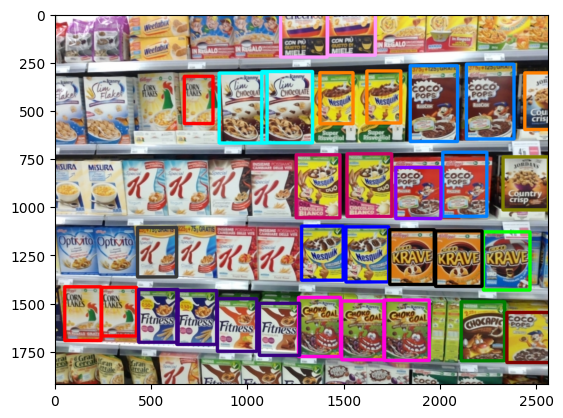

-------------------------------------------------------------------------------------------------
Product 0 - 1 instance(s) found:
     Instance 1 {position: (1312,1353), width: 236px, height: 310px}
Product 1 - 1 instance(s) found:
     Instance 1 {position: (2030,1335), width: 229px, height: 288px}
Product 2 - 2 instance(s) found:
     Instance 1 {position: (59,520), width: 258px, height: 375px}
     Instance 2 {position: (340,524), width: 254px, height: 383px}
Product 3 - 2 instance(s) found:
     Instance 1 {position: (1066,1764), width: 259px, height: 345px}
     Instance 2 {position: (1316,1770), width: 239px, height: 343px}
Product 4 - 2 instance(s) found:
     Instance 1 {position: (600,514), width: 298px, height: 403px}
     Instance 2 {position: (868,523), width: 282px, height: 402px}
Product 5 - 2 instance(s) found:
     Instance 1 {position: (1158,472), width: 185px, height: 282px}
     Instance 2 {position: (1418,477), width: 184px, height: 284px}
Product 6 - 0 instance(s)

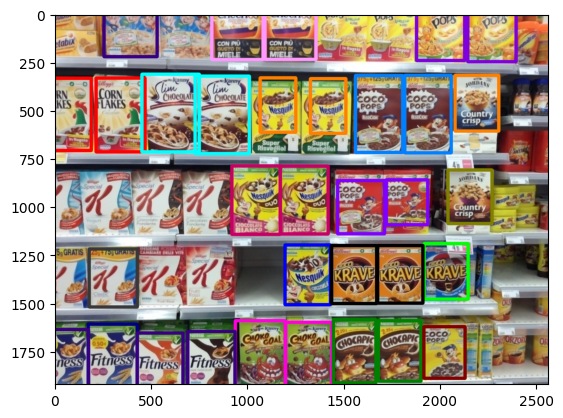

-------------------------------------------------------------------------------------------------
Product 0 - 2 instance(s) found:
     Instance 1 {position: (894,1360), width: 233px, height: 300px}
     Instance 2 {position: (1136,1356), width: 229px, height: 296px}
Product 1 - 1 instance(s) found:
     Instance 1 {position: (1856,1354), width: 233px, height: 305px}
Product 2 - 1 instance(s) found:
     Instance 1 {position: (121,485), width: 188px, height: 272px}
Product 3 - 3 instance(s) found:
     Instance 1 {position: (884,1764), width: 233px, height: 317px}
     Instance 2 {position: (1113,1774), width: 246px, height: 319px}
     Instance 3 {position: (1350,1770), width: 250px, height: 323px}
Product 4 - 2 instance(s) found:
     Instance 1 {position: (410,552), width: 263px, height: 398px}
     Instance 2 {position: (661,552), width: 290px, height: 405px}
Product 5 - 2 instance(s) found:
     Instance 1 {position: (949,504), width: 186px, height: 285px}
     Instance 2 {positio

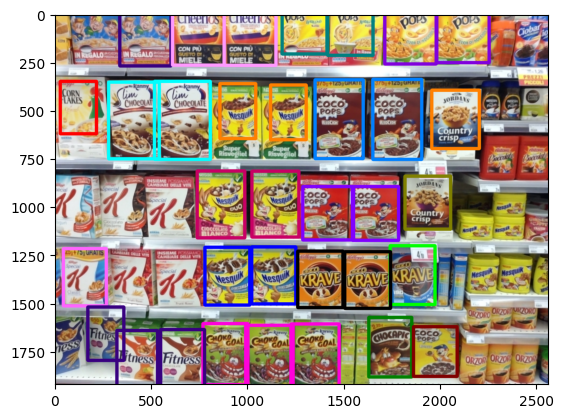

-------------------------------------------------------------------------------------------------


In [12]:
for img_train in img_trains:
    img_train_c = img_train.copy()
    kp_train, des_train = get_kp_and_des(img_train)
    instances_info = []
    
    
    for img_query in img_queries:       
        instances_info_query = []
        
        kp_query, des_query = get_kp_and_des(img_query)
        good = match_descriptors(des_query,des_train)
        
        accumulator,train_barycentres = generalized_hough(img_train, kp_query, kp_train, good, 50)
        
        maxima_rows,maxima_cols,maxima_values = find_maxima(accumulator,good,60,40,0.0028)
        
        for maxima_row,maxima_col,maxima_value in zip(maxima_rows,maxima_cols,maxima_values):
            M = calculate_homography(kp_query,kp_train,good,train_barycentres,maxima_row,maxima_col)
            # Corners of the query image
            h,w,_ = img_query.shape
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

            # Projecting the corners into the train image
            dst = cv2.perspectiveTransform(pts,M)
            
            dst,box_width,box_height,box_center= approximate_rectangle(dst,img_train[:,:,0].shape)
            instance_info = (box_width,box_height,box_center,maxima_value,dst)
            
            instances_info,check = check_double_matches(instances_info,instance_info)
            if check:
                instances_info_query.append(instance_info)
        instances_info.append(instances_info_query)

    
    
    #draw found instances and print information
    for instances_info_query,color,name in zip(instances_info,colors,queries):
        inst_num = 0
        found_instances = len(instances_info_query)
        print("Product {} - {} instance(s) found:".format(name,found_instances))
        for instance_info in instances_info_query: 
            # Drawing the bounding box
            img_train_c = cv2.polylines(img_train_c,[np.int32(instance_info[4])],True,color,15, cv2.LINE_AA)
            # printing information
            box_width = instance_info[0]
            box_height = instance_info[1]
            box_center = instance_info[2]
            inst_num +=1
            print("     Instance {} {{position: ({},{}), width: {}px, height: {}px}}".format(inst_num,box_center[0],box_center[1],box_width,box_height))
   
    plt.imshow(cv2.cvtColor(img_train_c, cv2.COLOR_BGR2RGB))
    plt.show()
    print("-------------------------------------------------------------------------------------------------")

### 12- Conclusions
From the obtained results, it can be seen that the applied object detection pipeline achieves good but not optimal results. It correctly identifies the majority of the products on the shelves, although sometimes products are identified as similar but of a different type (as seen, for example, with products 12, 13, 24). It is also noticeable that the detection method used is not very effective when there are numerous instances of the same object in the scene. In these cases, no instances (or only a minimal part) of the object present in the scene are detected.